In [77]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)

img1 = cv2.imread('RGB4.JPG')
imgRGB = cv2.resize(img1, (600, 450))
img1 = cv2.cvtColor(imgRGB, cv2.COLOR_BGR2GRAY)
RGB = imgRGB.copy()

img2 = cv2.imread('NIR4.JPG')
imgNIR = cv2.resize(img2, (600, 450))
NIR = imgNIR.copy()
img2 = imgNIR[:, :, 2]

akaze = cv2.xfeatures2d.SIFT_create()

kp1, des1 = akaze.detectAndCompute(img1, None)
kp2, des2 = akaze.detectAndCompute(img2, None)
print(f"Keypoints RGB: {len(kp1)}, {des1.shape}")
print(f"Keypoints NIR: {len(kp2)}, {des2.shape}")

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k = 2)
print(f"Matches: {len(matches)}")
good_matches = []

for m,n in matches:

    if m.distance < 0.6*n.distance:
        good_matches.append([m])

print(f"Good matches: {len(good_matches)}")
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


ref_matched_kpts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
sensed_matched_kpts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])
print(len(ref_matched_kpts), len(sensed_matched_kpts))
# Compute homography
H, status = cv2.findHomography(sensed_matched_kpts, ref_matched_kpts, cv2.RANSAC,5.0)

# Warp image
warped_image = cv2.warpPerspective(imgNIR, H, (img2.shape[1], img2.shape[0]))
imgRGB[:, :, 2] = imgNIR[:, :, 0]
imo = imgRGB.copy()

imgRGB[:, :, 2] = warped_image[:, :, 0]
t = np.vstack((imo, imgRGB))

Keypoints RGB: 542, (542, 128)
Keypoints NIR: 1920, (1920, 128)
Matches: 542
Good matches: 25
25 25


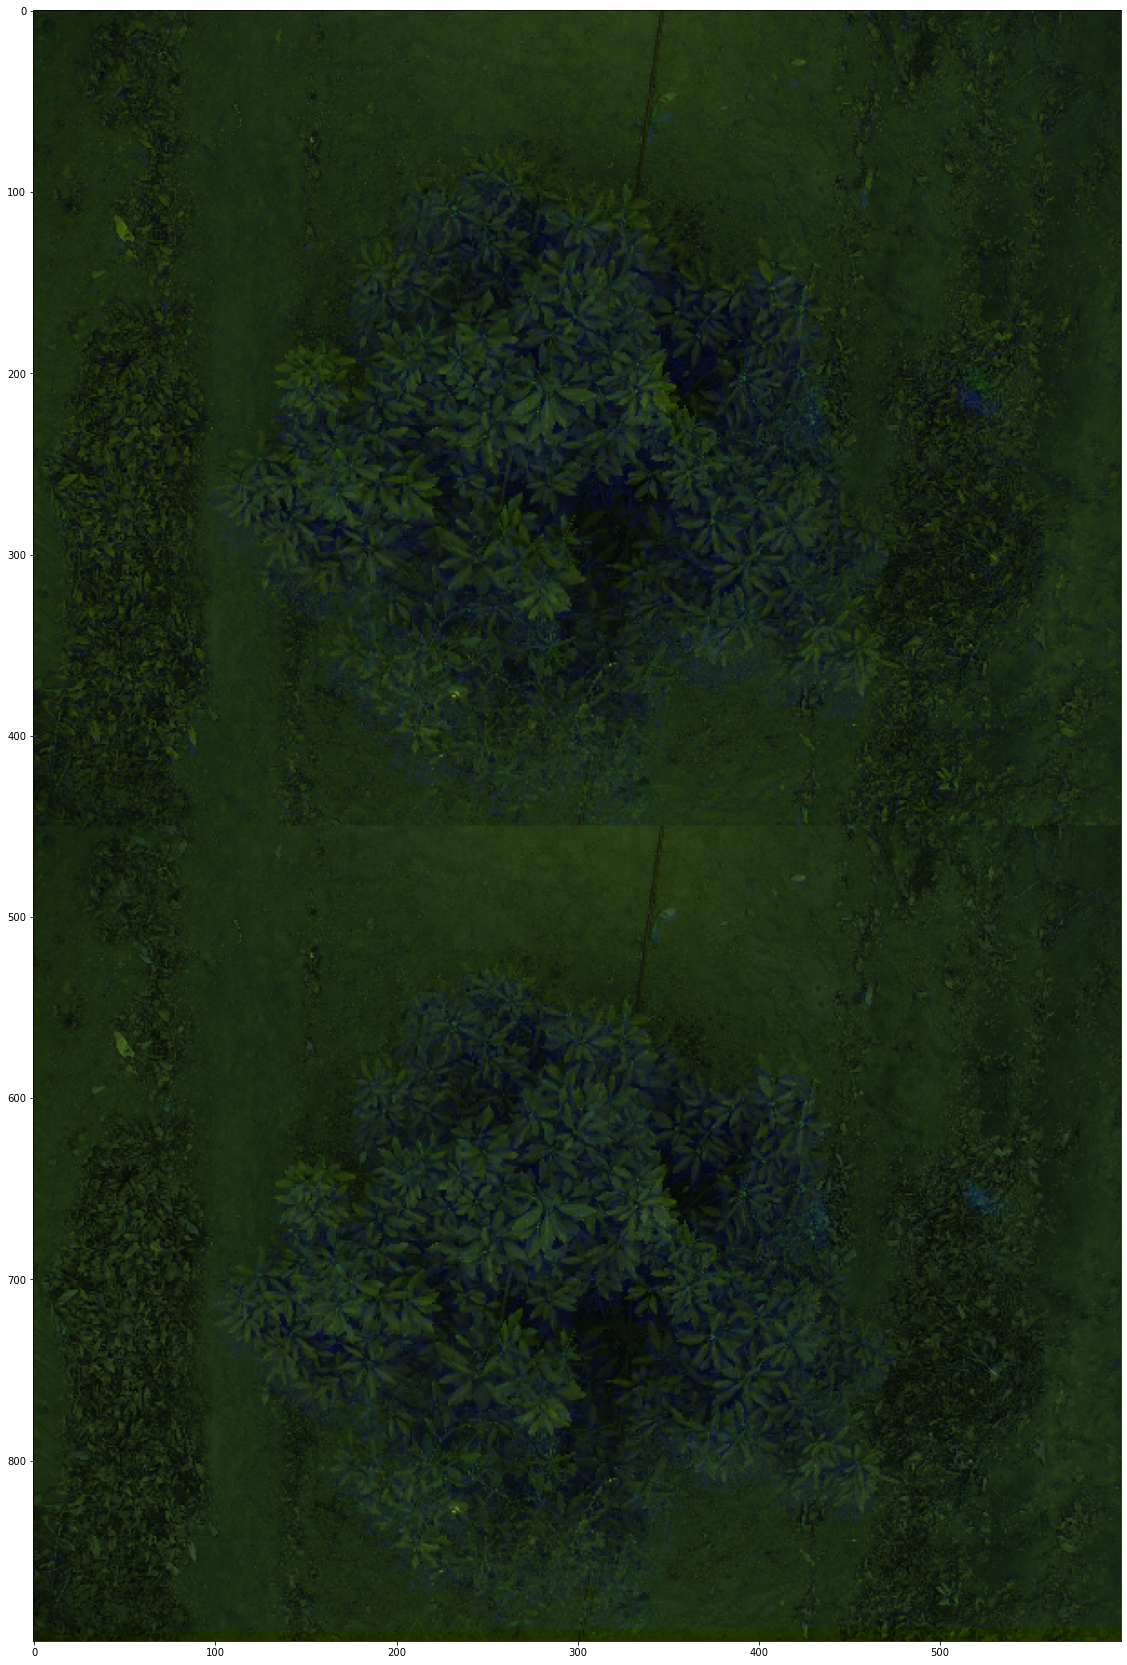

In [78]:
plt.imshow(t)

In [79]:
RGB = RGB.astype(np.float64)
warped_image = warped_image.astype(np.float64)

In [80]:
RR = np.array([[1.377, -0.182, -0.061],
              [-0.199, 1.420, -0.29],
              [-0.034, -0.110, 1.150]])
RN = np.array([[-0.956, 0., 1.],
              [2.426, 0., -0.341],
              [0., 1., 0.]])

In [81]:
RGB_ = np.matmul(RGB, RR)
NIR_ = np.matmul(warped_image, RN)

In [82]:
NDVI = (2.7*NIR_[:, :, 1]-RGB_[:, :, 2])/(2.7*NIR_[:, :, 1]+RGB_[:, :, 2])

In [83]:
NDVI

array([[-1.        , -0.6112964 ,  0.48649992, ...,  0.57581626,
         0.59283682,  0.60122299],
       [-1.        , -0.50433705,  0.51502514, ...,  0.58421123,
         0.57789587,  0.58650988],
       [-1.        , -0.39899833,  0.6081369 , ...,  0.5675098 ,
         0.60402318,  0.56094544],
       ...,
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

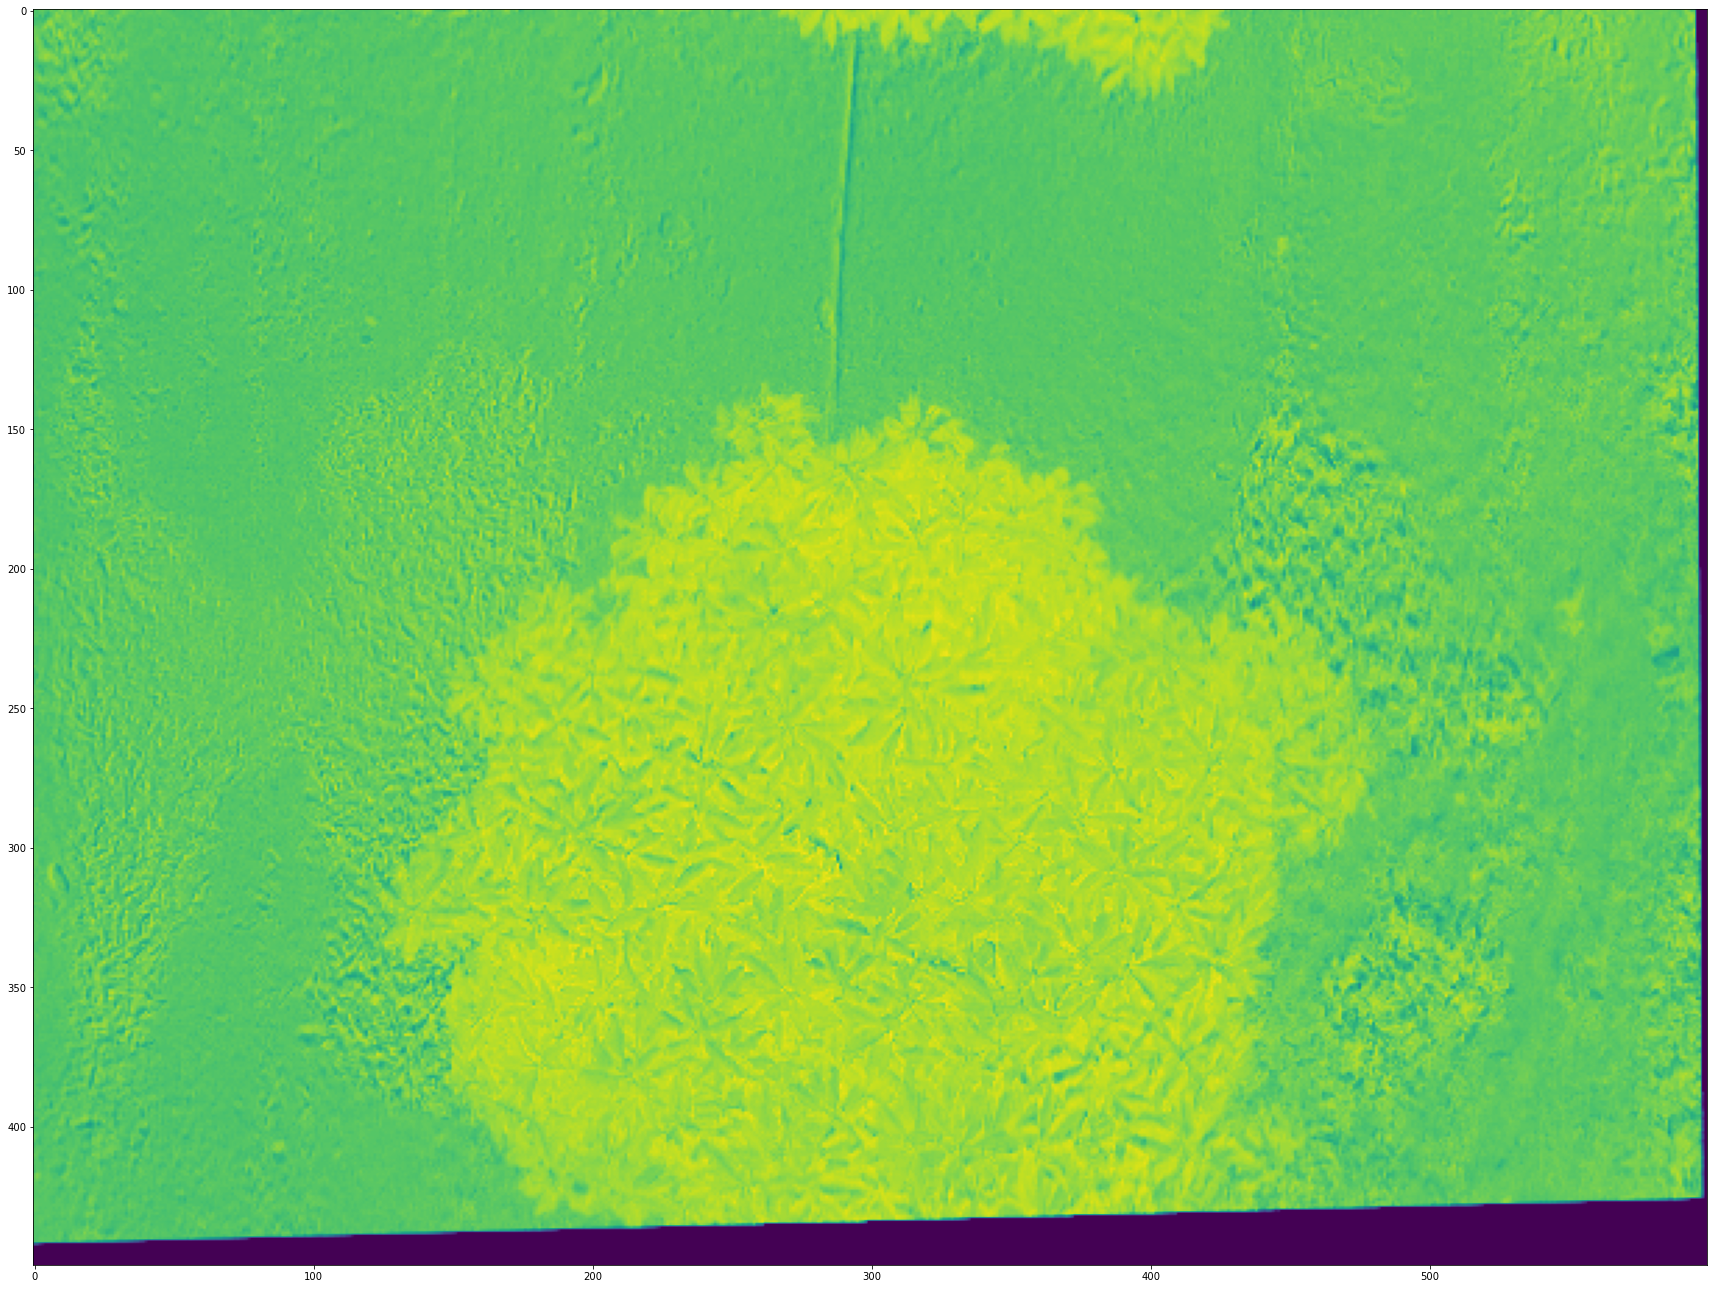

In [76]:
plt.imshow(NDVI)